In [15]:
import nltk
nltk.download("popular")

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import seaborn as sn
#import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

# Multi-Class Text Classification Model Comparison and Selection
inspired by https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

dataset used for multiclassification task : large data set of Stack Overflow questions and tags, publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

## Dataset preparation

### loading dataset

In [4]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum())

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs
10286120


### exploring the dataset
- Is dataset balanced ?
- Dataset content

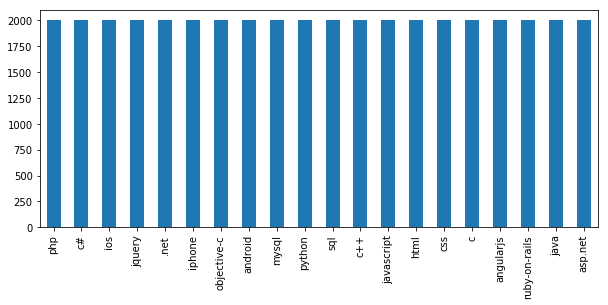

In [5]:
my_tags = ['java','html','asp.net','c#','ruby-on-rails','jquery','mysql','php','ios','javascript','python','c','css','android','iphone','sql','objective-c','c++','angularjs','.net']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [6]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

In [7]:
print_plot(30)

how to chain expressions inside ngclass when using the {...}[] form  how can i add another expression to an <code>ng-class</code> directive that uses this form:   <pre><code>ng-class= {true: loading   false: loading-done }[data.loader===null]  </code></pre>   i d like to add something like this to the list:   <pre><code>{highlight:isspecial} </code></pre>   is it possible without expanding the first expression     thanks.
Tag: angularjs


### cleanning dataset

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)
print_plot(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


In [9]:
print_plot(30)

chain expressions inside ngclass using form add another expression ngclass directive uses form ngclass true loading false loadingdone dataloadernull like add something like list highlightisspecial possible without expanding first expression thanks
Tag: angularjs


In [10]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424297

### splitting dataset for training

In [0]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Naive Bayer Classification

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


accuracy 0.7395
               precision    recall  f1-score   support

         java       0.63      0.65      0.64       613
         html       0.94      0.86      0.90       620
      asp.net       0.87      0.92      0.90       587
           c#       0.70      0.77      0.73       586
ruby-on-rails       0.73      0.87      0.79       599
       jquery       0.72      0.51      0.60       589
        mysql       0.77      0.74      0.75       594
          php       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
   javascript       0.57      0.65      0.60       587
       python       0.70      0.50      0.59       611
            c       0.79      0.78      0.79       594
          css       0.84      0.59      0.69       619
      android       0.66      0.84      0.74       574
       iphone       0.64      0.83      0.72       584
          sql       0.66      0.64      0.65       578
  objective-c       0.79      0.77      0.78    

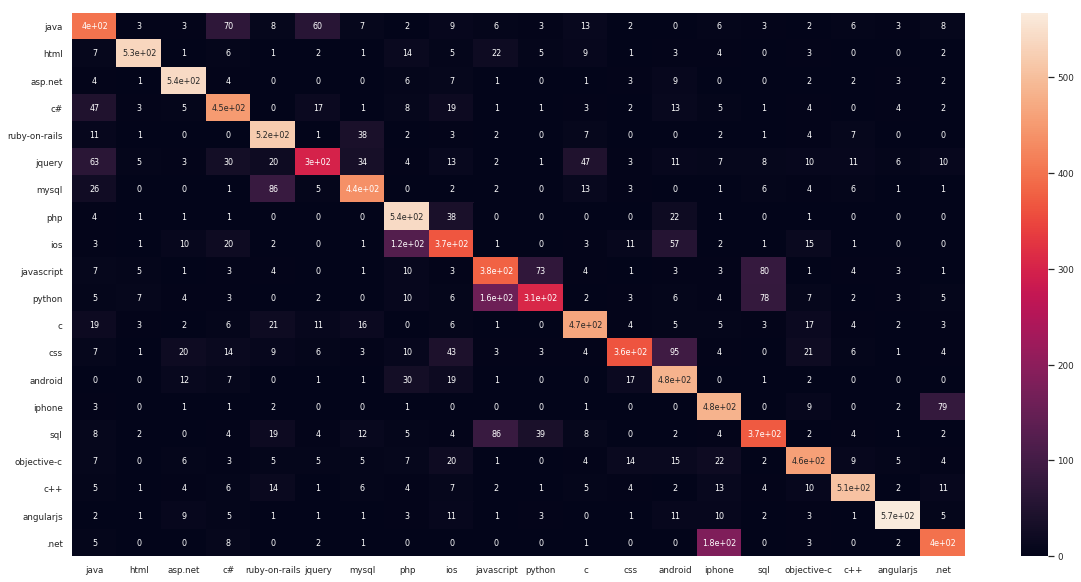

In [16]:
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=my_tags, columns=my_tags)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size


## Linear Support Vector Machine

In [0]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7895833333333333
               precision    recall  f1-score   support

         java       0.73      0.67      0.70       613
         html       0.84      0.94      0.89       620
      asp.net       0.88      0.95      0.92       587
           c#       0.81      0.80      0.80       586
ruby-on-rails       0.73      0.89      0.80       599
       jquery       0.77      0.39      0.52       589
        mysql       0.81      0.69      0.74       594
          php       0.71      0.95      0.81       610
          ios       0.83      0.57      0.67       617
   javascript       0.72      0.58      0.64       587
       python       0.71      0.65      0.68       611
            c       0.79      0.88      0.83       594
          css       0.77      0.79      0.78       619
      android       0.84      0.86      0.85       574
       iphone       0.82      0.81      0.81       584
          sql       0.70      0.68      0.69       578
  objective-c       0.81      0.90  

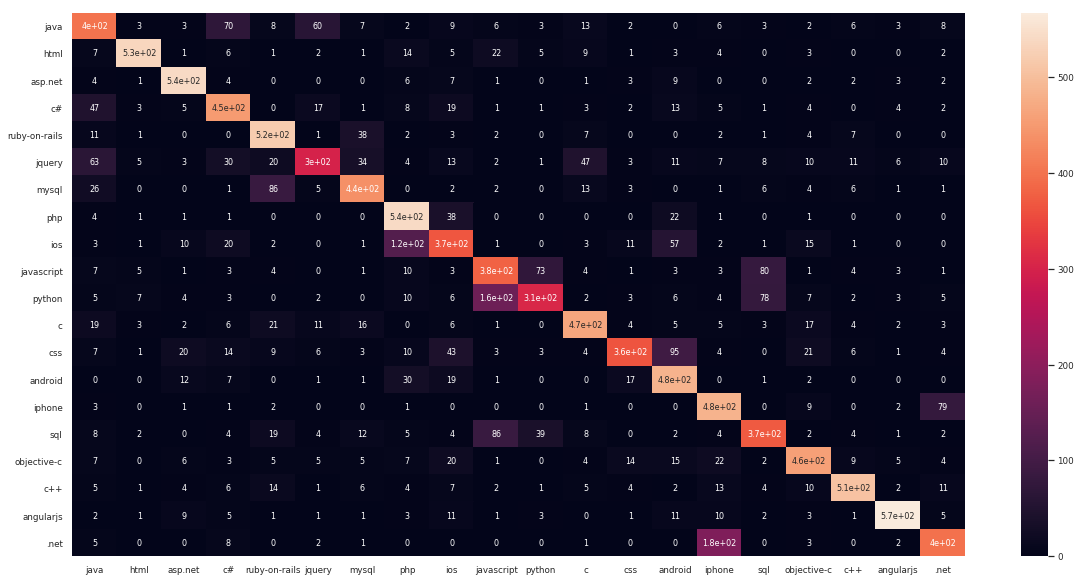

In [17]:
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=my_tags, columns=my_tags)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.78175
               precision    recall  f1-score   support

         java       0.70      0.62      0.66       613
         html       0.91      0.91      0.91       620
      asp.net       0.97      0.94      0.95       587
           c#       0.77      0.77      0.77       586
ruby-on-rails       0.77      0.81      0.79       599
       jquery       0.59      0.58      0.59       589
        mysql       0.78      0.75      0.76       594
          php       0.82      0.85      0.83       610
          ios       0.69      0.71      0.70       617
   javascript       0.61      0.59      0.60       587
       python       0.64      0.63      0.63       611
            c       0.82      0.83      0.83       594
          css       0.78      0.78      0.78       619
      android       0.84      0.85      0.84       574
       iphone       0.80      0.83      0.82       584
          sql       0.65      0.64      0.65       578
  objective-c       0.82      0.85      0.83   

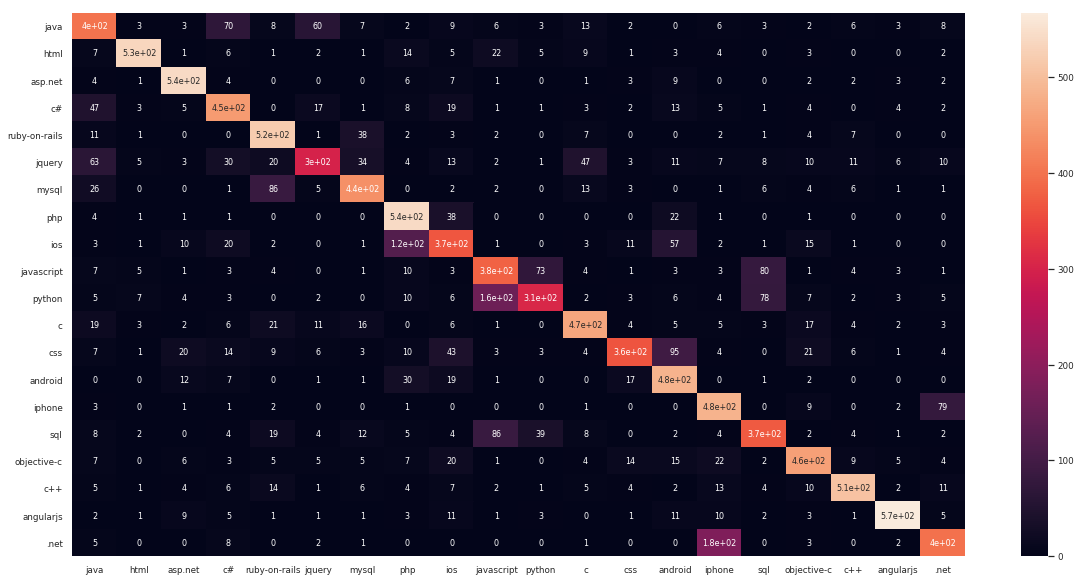

In [18]:
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=my_tags, columns=my_tags)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size

## Word2Vec & embeddings
Word2vec is a type of mapping that allows words with similar meaning to have similar vector representation.

The idea behind Word2vec is rather simple: we want to use the surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.

### loading precomputed embeddings

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [23]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [0]:
# BOW based approaches that includes averaging, summation, weighted addition. The common way is to average the two word vectors. Therefore, we will follow the most common way.

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [25]:
# We will tokenize the text and apply the tokenization to “post” column, and apply word vector averaging to tokenized text.

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### word2vec & logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.6380833333333333
               precision    recall  f1-score   support

         java       0.63      0.59      0.61       613
         html       0.74      0.76      0.75       620
      asp.net       0.65      0.67      0.66       587
           c#       0.53      0.52      0.52       586
ruby-on-rails       0.70      0.77      0.73       599
       jquery       0.44      0.39      0.41       589
        mysql       0.65      0.60      0.63       594
          php       0.73      0.80      0.76       610
          ios       0.61      0.61      0.61       617
   javascript       0.56      0.52      0.54       587
       python       0.55      0.50      0.52       611
            c       0.61      0.61      0.61       594
          css       0.65      0.65      0.65       619
      android       0.61      0.57      0.59       574
       iphone       0.70      0.71      0.70       584
          sql       0.43      0.43      0.43       578
  objective-c       0.68      0.71  

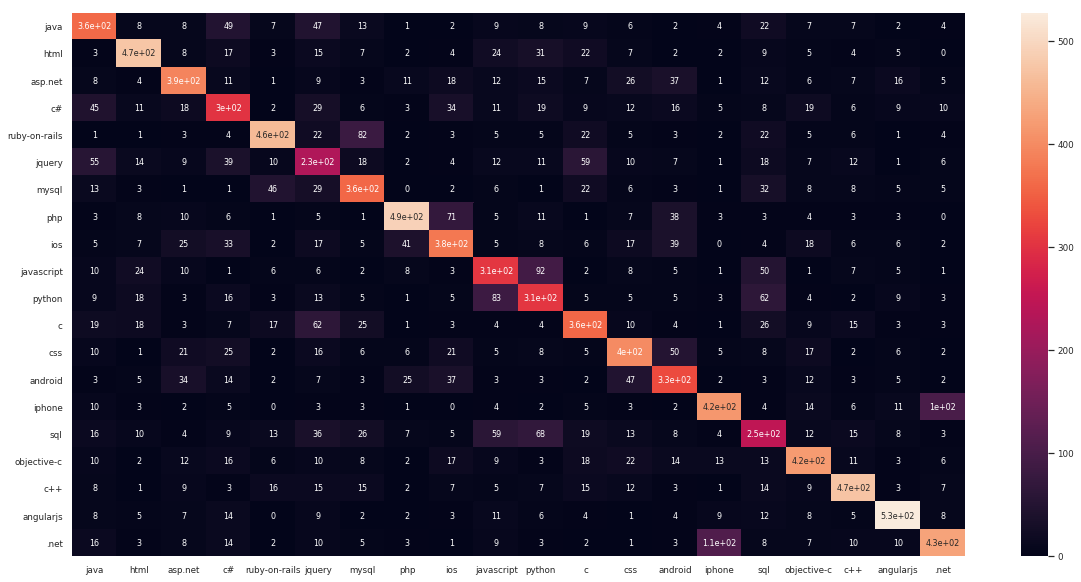

In [27]:
df_cm = pd.DataFrame(confusion_matrix(y_pred, test.tags),index=my_tags, columns=my_tags)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size

### Doc2Vec & Logistic Regression

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [29]:
all_data[:2]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', '11', 'auto_increment', 'name', 'varchar', '150', 'lastname', 'varchar', '150', 'company', 'varchar', '250', 'adress', 'varchar', '150', 'postcode', 'int', '5', 'city', 'varchar', '150', 'email', 'varchar', '250', 'phone', 'varchar', '20', 'orgnr', 'varchar', '15', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name',

In [30]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 40000/40000 [00:00<00:00, 2984367.01it/s]


In [0]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [33]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.8093333333333333
               precision    recall  f1-score   support

         java       0.70      0.68      0.69       589
         html       0.89      0.91      0.90       661
      asp.net       0.93      0.96      0.94       606
           c#       0.79      0.78      0.78       613
ruby-on-rails       0.82      0.90      0.86       601
       jquery       0.70      0.69      0.70       585
        mysql       0.88      0.80      0.84       621
          php       0.83      0.87      0.85       587
          ios       0.69      0.67      0.68       560
   javascript       0.69      0.65      0.67       611
       python       0.67      0.69      0.68       593
            c       0.81      0.85      0.83       581
          css       0.80      0.77      0.79       608
      android       0.85      0.85      0.85       593
       iphone       0.86      0.82      0.84       592
          sql       0.73      0.66      0.69       597
  objective-c       0.85      0.88  

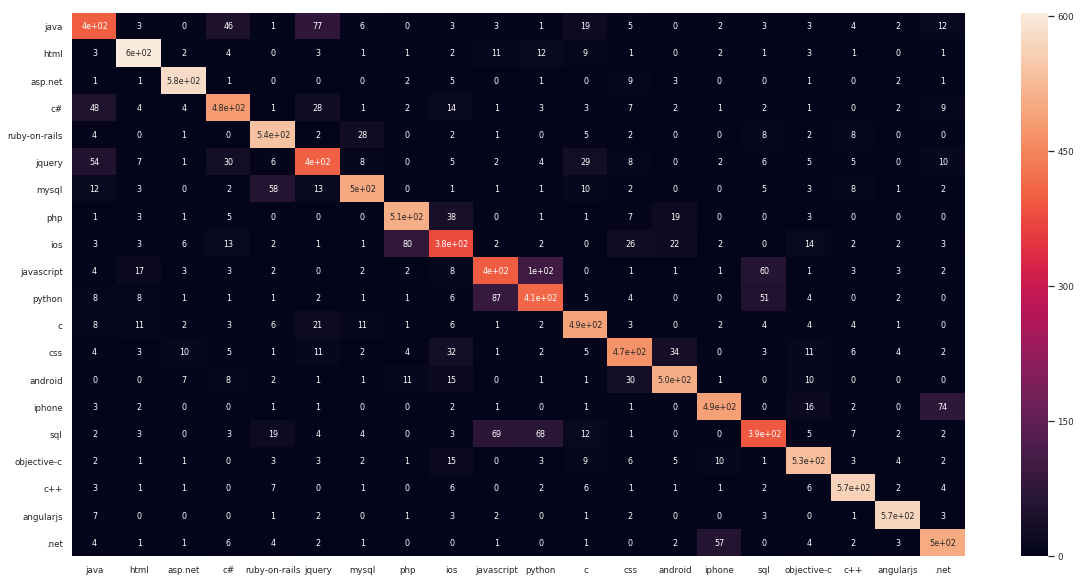

In [34]:
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=my_tags, columns=my_tags)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size

## Keras Bag of words

In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

12000/12000 [==============================] - 0s 36us/step
Test accuracy: 0.794


Notes :
* https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
* https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
